In [126]:
import numpy as np
import mne
import numpy as np

STRIDE_SEC = 5
EPOCH_SEC_SIZE = 30
channel_eeg = 6

memmap_eeg_data = np.memmap('/Users/lejieliu/Documents/CS189/lucid-dreaming-core/app/recorded_data/20250530_194534_431242/1748648741.316674/eeg.dat', dtype=np.float64, mode='r')
l_eeg = int(len(memmap_eeg_data)//channel_eeg)

eeg_data = np.array(memmap_eeg_data)[:l_eeg*channel_eeg].reshape((l_eeg, channel_eeg))

raw_data = eeg_data[:, [0, 1, 3, 4]].T * 1e-8



channel_names = ['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']
sfreq = 125 

info = mne.create_info(
    ch_names=channel_names,
    sfreq=sfreq,
    ch_types=["eeg"] * len(channel_names)
)

raw = mne.io.RawArray(raw_data, info)
raw.pick_channels(['RF-FpZ'])
raw.filter(0.35, 40)
raw = raw.resample(100)
sfreq = 100
data = raw.to_data_frame()['RF-FpZ']
n_samples = len(data)

epoch_len = int(EPOCH_SEC_SIZE * sfreq)
stride_len = int(STRIDE_SEC * sfreq)

n_epoch = (n_samples - epoch_len) // stride_len + 1

epochs = []
labels = []
for i in range(n_epoch):
    start = i * stride_len
    end = start + epoch_len
    if end > n_samples:
        break
    epoch_data = np.array(data[start:end])

    # z-score
    m = np.mean(epoch_data)
    s = np.std(epoch_data) + 1e-8
    epoch_data = (epoch_data - m) / s

    epochs.append(epoch_data)

epochs = np.stack(epochs, axis=0) if epochs else np.empty((0, 1, epoch_len))

print("realtime data epochs shape:", epochs.shape)  # (n_epoch, n_channels, epoch_len)

Creating RawArray with float64 data, n_channels=4, n_times=38835
    Range : 0 ... 38834 =      0.000 ...   310.672 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.35 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.35
- Lower transition bandwidth: 0.35 Hz (-6 dB cutoff frequency: 0.17 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1179 samples (9.432 s)

realtime data epochs shape: (57, 3000)


In [118]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import mne
import matplotlib.pyplot as plt
class DeepSleepNetBinary(nn.Module):
    def __init__(self, input_len=3000, cnn_feat_dim=128, lstm_hidden=128, seq_len=20):
        super().__init__()
        # Multi-scale CNN branch 1 (large kernel)
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=400, stride=50, padding=0),  # (batch, 64, ?)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(64, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        # Multi-scale CNN branch 2 (small kernel)
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=50, stride=6, padding=0),  # (batch, 64, ?)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(8),
            nn.Conv1d(64, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        # 计算flatten后输出的特征维度
        with torch.no_grad():
            dummy = torch.randn(1, 1, input_len)
            feat1 = self.cnn1(dummy).view(1, -1).shape[1]
            feat2 = self.cnn2(dummy).view(1, -1).shape[1]
        self.cnn_out_dim = feat1 + feat2

        # 全连接用于 residual shortcut，输出改为256
        self.fc_residual = nn.Sequential(
            nn.Linear(self.cnn_out_dim, 256),  # <--- 改这里
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=self.cnn_out_dim,
            hidden_size=lstm_hidden,
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True,
        )
        # Output layer: binary classification
        self.final_fc = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, 3000)
        b, t, n = x.shape
        x = x.view(b * t, 1, n)  # (batch*seq, 1, 3000)
        # Multi-scale CNN
        x1 = self.cnn1(x).view(b * t, -1)
        x2 = self.cnn2(x).view(b * t, -1)
        cnn_feat = torch.cat([x1, x2], dim=1)  # (batch*seq, feat)
        # Residual shortcut
        res_feat = self.fc_residual(cnn_feat)  # (batch*seq, 256)
        # Reshape for LSTM
        cnn_feat_seq = cnn_feat.view(b, t, -1)  # (batch, seq_len, feat)
        # LSTM
        lstm_out, _ = self.lstm(cnn_feat_seq)
        # 用最后一个时刻的 LSTM 输出
        lstm_last = lstm_out[:, -1, :]  # (batch, hidden*2=256)
        # Add residual (res_feat 对应最后一帧)
        res_feat_seq = res_feat.view(b, t, -1)[:, -1, :]  # (batch, 256)
        fused = lstm_last + res_feat_seq  # (batch, 256)
        # Output
        logits = self.final_fc(fused).squeeze(1)  # (batch,)
        return logits

In [119]:
fs = 100
seq_len = 5
epoch_sec = 30
input_len = epoch_sec * fs    
model_weight_path = '/Users/lejieliu/Documents/CS189/lucid-dreaming-core/models/alertness_torch_weights_salt.pth'

model = DeepSleepNetBinary(input_len=3000, seq_len=seq_len)
model.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
model.eval()

DeepSleepNetBinary(
  (cnn1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(400,), stride=(50,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(6,), stride=(1,), padding=(3,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=(3,))
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=(3,))
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn2): Sequential(
    (0): Conv1d(1, 64, kernel_size=(50,), stride=(6,))
    (1): Batc

In [130]:
seq_len = 5
X_seq = []
for i in range(len(epochs) - seq_len + 1):
    X_seq.append(epochs[i:i+seq_len])
X_seq = np.stack(X_seq, axis=0)

model.eval()
y_pred_list = []
batch_size = 64

X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)

with torch.no_grad():
    for i in range(0, len(X_seq_tensor), batch_size):
        xb = X_seq_tensor[i:i+batch_size]
        logits = model(xb)
        # 如果是sigmoid二分类
        probs = 1 - torch.sigmoid(logits).cpu().numpy().flatten()
        y_pred_list.append(probs)

y_pred = np.concatenate(y_pred_list)
print("预测结果 shape:", y_pred.shape)

预测结果 shape: (53,)


In [131]:
y_pred_ema = pd.Series(y_pred).ewm(span=1).mean()

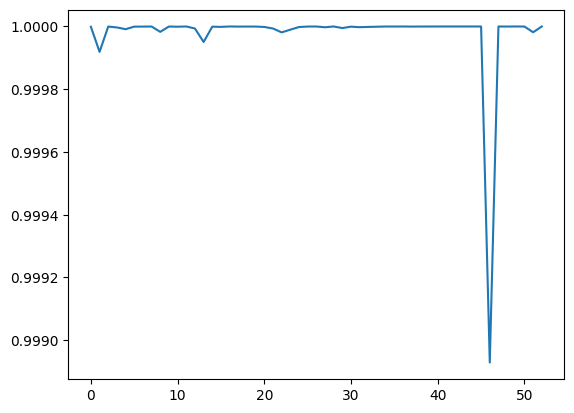

In [132]:
plt.plot(y_pred_ema)

In [108]:
def predict_alertness_ema(eeg_raw, ema_span=200):

    if not hasattr(predict_alertness_ema, "alertness_history"):
        predict_alertness_ema.alertness_history = []

    channel_names = ['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']
    sfreq = 125 

    info = mne.create_info(
        ch_names=channel_names,
        sfreq=sfreq,
        ch_types=["eeg"] * len(channel_names)
    )

    raw = mne.io.RawArray(eeg_raw, info)
    raw.pick_channels(['RF-FpZ'])

    raw.filter(0.35, 40)
    raw = raw.resample(100)
    sfreq = 100

    eeg_raw = raw.to_data_frame()['RF-FpZ'].to_numpy()
    # 分chunk
    chunks = [eeg_raw[i*input_len : (i+1)*input_len] for i in range(seq_len)]
    # 每个epoch做z-score
    chunks_zscore = []
    for arr in chunks:
        arr = np.asarray(arr)
        m = arr.mean()
        s = arr.std() + 1e-8
        arr_norm = (arr - m) / s
        chunks_zscore.append(arr_norm)
    segs = np.stack(chunks_zscore, axis=0)     # (seq_len, input_len)
    segs = segs[None, :, None :]          
    x_tensor = torch.from_numpy(segs.astype(np.float32))
    with torch.no_grad():
        out = model(x_tensor)
        alertness_score = (1 - torch.sigmoid(out).item())
    predict_alertness_ema.alertness_history.append(alertness_score)
    series = pd.Series(predict_alertness_ema.alertness_history)
    # ewm_score = series.ewm(span=ema_span, adjust=False).mean().iloc[-1]

    return alertness_score


In [110]:
predict_alertness_ema(raw_data[:, (s_len) * 21: (s_len) * 22])

Creating RawArray with float64 data, n_channels=4, n_times=18750
    Range : 0 ... 18749 =      0.000 ...   149.992 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.35 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.35
- Lower transition bandwidth: 0.35 Hz (-6 dB cutoff frequency: 0.17 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1179 samples (9.432 s)



0.005168497562408447

In [88]:
eeg_raw = raw_data[:, (s_len) * 10: (s_len) * 11]

channel_names = ['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']
sfreq = 125 

info = mne.create_info(
    ch_names=channel_names,
    sfreq=sfreq,
    ch_types=["eeg"] * len(channel_names)
)

raw = mne.io.RawArray(eeg_raw, info)
raw.pick_channels(['RF-FpZ'])

raw.filter(0.35, 40)
raw = raw.resample(100)
sfreq = 100

eeg_raw = raw.to_data_frame()['RF-FpZ']
# # 分chunk
chunks = [eeg_raw[i*input_len : (i+1)*input_len] for i in range(seq_len)]
# # 每个epoch做z-score
chunks_zscore = []
for arr in chunks:
    arr = np.asarray(arr)
    m = arr.mean()
    s = arr.std() + 1e-8
    arr_norm = (arr - m) / s
    chunks_zscore.append(arr_norm)
segs = np.stack(chunks_zscore, axis=0)     # (seq_len, input_len)
# segs = segs[None, :, :]          
# x_tensor = torch.from_numpy(segs.astype(np.float32))
# with torch.no_grad():
#     out = model(x_tensor)
#     alertness_score = (1 - torch.sigmoid(out).cpu())
# predict_alertness_ema.alertness_history.append(alertness_score)
# series = pd.Series(predict_alertness_ema.alertness_history)
# ewm_score = series.ewm(span=ema_span, adjust=False).mean().iloc[-1]

Creating RawArray with float64 data, n_channels=4, n_times=15000
    Range : 0 ... 14999 =      0.000 ...   119.992 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.35 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.35
- Lower transition bandwidth: 0.35 Hz (-6 dB cutoff frequency: 0.17 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1179 samples (9.432 s)



/var/folders/68/l7xp6fns3w92gfhrl5cn9x940000gn/T/ipykernel_57881/3303704789.py:26: RuntimeWarning: Mean of empty slice.
  m = arr.mean()
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: all input arrays must have the same shape

In [162]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import mne
from datetime import datetime
import os

class DeepSleepNetBinary(nn.Module):
    def __init__(self, input_len=3000, cnn_feat_dim=128, lstm_hidden=128, seq_len=20):
        super().__init__()
        # Multi-scale CNN branch 1 (large kernel)
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=400, stride=50, padding=0),  # (batch, 64, ?)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(64, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        # Multi-scale CNN branch 2 (small kernel)
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=50, stride=6, padding=0),  # (batch, 64, ?)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(8),
            nn.Conv1d(64, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        # 计算flatten后输出的特征维度
        with torch.no_grad():
            dummy = torch.randn(1, 1, input_len)
            feat1 = self.cnn1(dummy).view(1, -1).shape[1]
            feat2 = self.cnn2(dummy).view(1, -1).shape[1]
        self.cnn_out_dim = feat1 + feat2

        # 全连接用于 residual shortcut，输出改为256
        self.fc_residual = nn.Sequential(
            nn.Linear(self.cnn_out_dim, 256),  # <--- 改这里
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=self.cnn_out_dim,
            hidden_size=lstm_hidden,
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True,
        )
        # Output layer: binary classification
        self.final_fc = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, 3000)
        b, t, n = x.shape
        x = x.view(b * t, 1, n)  # (batch*seq, 1, 3000)
        # Multi-scale CNN
        x1 = self.cnn1(x).view(b * t, -1)
        x2 = self.cnn2(x).view(b * t, -1)
        cnn_feat = torch.cat([x1, x2], dim=1)  # (batch*seq, feat)
        # Residual shortcut
        res_feat = self.fc_residual(cnn_feat)  # (batch*seq, 256)
        # Reshape for LSTM
        cnn_feat_seq = cnn_feat.view(b, t, -1)  # (batch, seq_len, feat)
        # LSTM
        lstm_out, _ = self.lstm(cnn_feat_seq)
        # 用最后一个时刻的 LSTM 输出
        lstm_last = lstm_out[:, -1, :]  # (batch, hidden*2=256)
        # Add residual (res_feat 对应最后一帧)
        res_feat_seq = res_feat.view(b, t, -1)[:, -1, :]  # (batch, 256)
        fused = lstm_last + res_feat_seq  # (batch, 256)
        # Output
        logits = self.final_fc(fused).squeeze(1)  # (batch,)
        return logits

class DeepSleepNetREMBinary(nn.Module):
    def __init__(self, input_len=3000, cnn_feat_dim=128, lstm_hidden=128, seq_len=20):
        super().__init__()
        # Multi-scale CNN branch 1 (large kernel)
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=400, stride=50, padding=0),  # (batch, 64, ?)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(64, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=6, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        # Multi-scale CNN branch 2 (small kernel)
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=50, stride=6, padding=0),  # (batch, 64, ?)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(8),
            nn.Conv1d(64, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        # 计算flatten后输出的特征维度
        with torch.no_grad():
            dummy = torch.randn(1, 1, input_len)
            feat1 = self.cnn1(dummy).view(1, -1).shape[1]
            feat2 = self.cnn2(dummy).view(1, -1).shape[1]
        self.cnn_out_dim = feat1 + feat2

        # 全连接用于 residual shortcut，输出改为256
        self.fc_residual = nn.Sequential(
            nn.Linear(self.cnn_out_dim, 256),  # <--- 改这里
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=self.cnn_out_dim,
            hidden_size=lstm_hidden,
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True,
        )
        # Output layer: binary classification
        self.final_fc = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, 3000)
        b, t, n = x.shape
        x = x.view(b * t, 1, n)  # (batch*seq, 1, 3000)
        # Multi-scale CNN
        x1 = self.cnn1(x).view(b * t, -1)
        x2 = self.cnn2(x).view(b * t, -1)
        cnn_feat = torch.cat([x1, x2], dim=1)  # (batch*seq, feat)
        # Residual shortcut
        res_feat = self.fc_residual(cnn_feat)  # (batch*seq, 256)
        # Reshape for LSTM
        cnn_feat_seq = cnn_feat.view(b, t, -1)  # (batch, seq_len, feat)
        # LSTM
        lstm_out, _ = self.lstm(cnn_feat_seq)
        # 用最后一个时刻的 LSTM 输出
        lstm_last = lstm_out[:, -1, :]  # (batch, hidden*2=256)
        # Add residual (res_feat 对应最后一帧)
        res_feat_seq = res_feat.view(b, t, -1)[:, -1, :]  # (batch, 256)
        fused = lstm_last + res_feat_seq  # (batch, 256)
        # Output
        logits = self.final_fc(fused).squeeze(1)  # (batch,)
        return logits



fs = 100
seq_len = 5
epoch_sec = 30
input_len = epoch_sec * fs

# Get the absolute path to the current file's directory (lucid-dreaming-core)
BASE_DIR = os.path.dirname("/Users/lejieliu/Documents/CS189/lucid-dreaming-core/")

model_weight_path = os.path.join(BASE_DIR, 'models', 'alertness_torch_weights_salt.pth')
model = DeepSleepNetBinary(input_len=3000, seq_len=seq_len)
model.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
model.eval()

rem_model_weight_path = os.path.join(BASE_DIR, 'models', 'REM_binary_model_weights.pth')
rem_seq_len = 5
rem_model = DeepSleepNetREMBinary(input_len=3000, seq_len=rem_seq_len)
rem_model.load_state_dict(torch.load(rem_model_weight_path, map_location='cpu'))
rem_model.eval()

# Set mne logging level to ERROR
mne.set_log_level('ERROR')

def predict_is_rem(eeg_raw, ema_span = 5):
    if not hasattr(predict_is_rem, "rem_history"):
        predict_is_rem.rem_history = []

    channel_names = ['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']
    sfreq = 125 

    info = mne.create_info(
        ch_names=channel_names,
        sfreq=sfreq,
        ch_types=["eeg"] * len(channel_names)
    )

    raw = mne.io.RawArray(eeg_raw, info)
    raw.pick_channels(['RF-FpZ'])

    raw.filter(0.1, 45)
    raw = raw.resample(100)

    eeg_raw = raw.to_data_frame()['RF-FpZ']
    
    chunks = [eeg_raw[i*input_len : (i+1)*input_len] for i in range(rem_seq_len)]
    
    chunks_zscore = []
    for arr in chunks:
        arr = np.asarray(arr)
        m = arr.mean()
        s = arr.std() + 1e-8
        arr_norm = (arr - m) / s
        chunks_zscore.append(arr_norm)
    segs = np.stack(chunks_zscore, axis=0)     # (seq_len, input_len)
    segs = segs[None, :, :]          
    x_tensor = torch.from_numpy(segs.astype(np.float32))
    with torch.no_grad():
        out = rem_model(x_tensor)
        rem_possibility = round(torch.sigmoid(out).item(), 4)
    predict_is_rem.rem_history.append(rem_possibility)
    return rem_possibility

def predict_alertness_ema(eeg_raw, ema_span=5):

    if not hasattr(predict_alertness_ema, "alertness_history"):
        predict_alertness_ema.alertness_history = []

    channel_names = ['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']
    sfreq = 125 

    info = mne.create_info(
        ch_names=channel_names,
        sfreq=sfreq,
        ch_types=["eeg"] * len(channel_names)
    )

    raw = mne.io.RawArray(eeg_raw, info)
    raw.pick_channels(['RF-FpZ'])

    raw.filter(0.35, 40)
    raw = raw.resample(100)

    eeg_raw = raw.to_data_frame()['RF-FpZ']

    chunks = [eeg_raw[i*input_len : (i+1)*input_len] for i in range(seq_len)]

    chunks_zscore = []
    for arr in chunks:
        arr = np.asarray(arr)
        m = arr.mean()
        s = arr.std() + 1e-8
        arr_norm = (arr - m) / s
        chunks_zscore.append(arr_norm)
    segs = np.stack(chunks_zscore, axis=0)    
    segs = segs[None, :, :]          
    x_tensor = torch.from_numpy(segs.astype(np.float32))
    with torch.no_grad():
        out = model(x_tensor)
        alertness_score = round(1 - torch.sigmoid(out).item(), 4)
    predict_alertness_ema.alertness_history.append(alertness_score)
    series = pd.Series(predict_alertness_ema.alertness_history)
    ewm_score = series.ewm(span=ema_span, adjust=False).mean().iloc[-1]
    return ewm_score




In [163]:
memmap_eeg_data = np.memmap('/Users/lejieliu/Documents/CS189/lucid-dreaming-core/app/recorded_data/20250601_033028_731725/1748763034.805182/eeg.dat', dtype=np.float64, mode='r')
l_eeg = int(len(memmap_eeg_data)//channel_eeg)

eeg_data = np.array(memmap_eeg_data)[:l_eeg*channel_eeg].reshape((l_eeg, channel_eeg))

raw_data = eeg_data[:, [0, 1, 3, 4]].T * 1e-8

In [164]:
# ---------- 1. 预设 ----------
fs_in          = 125                     # 原始采样率
sec_per_chunk  = seq_len * (input_len / 100)   # 5 * 30 = 150 s
needed_len_raw = int(sec_per_chunk * fs_in)    # 150 * 125 = 18 750 点
stride_raw     = fs_in * 30                  # 每 1 秒滑一次 (=125 点)

print(f"每次窗口 {needed_len_raw/fs_in:.0f}s, 点数={needed_len_raw}, 滑步={stride_raw} 点")

# ---------- 2. 滑窗预测 ----------
rem_prob_hist      = []       # 存 REM 概率
alertness_hist     = []       # 存警觉度
time_axis_seconds  = []       # 对应时间（秒）

for start in range(0, raw_data.shape[1] - needed_len_raw + 1, stride_raw):
    chunk = raw_data[:, start : start + needed_len_raw]   # (4, 18 750)

    # REM 概率
    rem_prob = predict_is_rem(chunk)
    rem_prob_hist.append(rem_prob)

    # 警觉度 (EMA 内部已累计)
    alertness = predict_alertness_ema(chunk)
    alertness_hist.append(alertness)

    time_axis_seconds.append(start / fs_in)   # 当前窗口起始时间

rem_prob_hist  = np.array(rem_prob_hist)
alertness_hist = np.array(alertness_hist)
time_axis_seconds = np.array(time_axis_seconds)

print("总窗口数:", len(rem_prob_hist))


每次窗口 150s, 点数=18750, 滑步=3750 点
总窗口数: 766


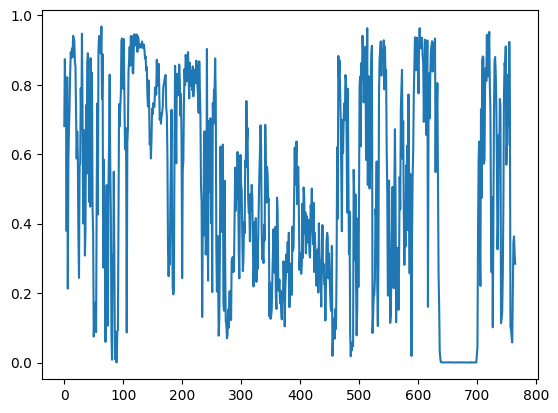

In [165]:
plt.plot(rem_prob_hist)

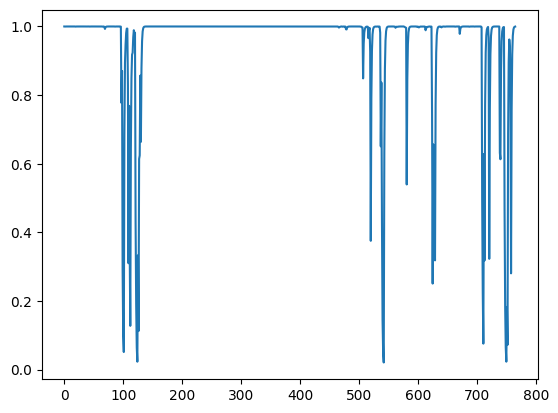

In [166]:
plt.plot(alertness_hist)